# Temperature Profile
This looks at the temperature profile, to see how it differs from the expected dry adiabat up to the LCL, followed by the moist adiabat.

In [143]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, radius_earth
from isca_tools.utils import area_weighting, annual_mean
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import interpolate
import matplotlib.animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [16]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'precipitation', 'omega', 't_ref', 'klzbs', 'ucomp', 'vcomp', 'flux_lhe', 'flux_t', 
            'dt_tg_diffusion', 'dt_tg_convection', 'dt_tg_condensation', 'tdt_rad', 
            'dt_qg_diffusion', 'dt_qg_convection', 'dt_qg_condensation']  
# Load dataset
tau_lw_ref = 1
exp_dir = 'aquaplanet/temp_tendency/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}"]
n_exp = len(exp_names)
ds_base = []
albedo = []
tau_sw = []
tau_lw = []

use_time_start = 360*2
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])
    try:
        ds_use = ds_use[var_keep]
    except KeyError:
        remove_keys = []
        for key in var_keep:
            if key not in ds_use:
                print(f'Removing {key} from var_keep')
                remove_keys += [key]
        for key in remove_keys:
            var_keep.remove(key)
        ds_use = ds_use[var_keep]
    ds_base += [ds_use.sel(time=slice(use_time_start, np.inf))]      # only keep after spin up
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one surface dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

Also get an equivalent dataset consisting of free troposphere rather than surface values: `ds_all_ft`.

In [17]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

## Single location as function of time

In [316]:
lat_sl = 9.8
lon_sl = 78             # keep away from prime meridian to stop periodicity errors
ds_sl = []
for i in tqdm(range(n_exp)):
    # ds_sl += [annual_mean(ds_base[i].sel(lat=lat_sl, lon=lon_sl, method='nearest').load())]
    ds_sl += [ds_base[i].sel(lat=lat_sl, lon=lon_sl, method='nearest').load()]
lat_ind_sl = int(np.where(ds_base[0].lat==ds_sl[0].lat)[0])
lon_ind_sl = int(np.where(ds_base[0].lon==ds_sl[0].lon)[0])

100%|██████████| 1/1 [00:42<00:00, 42.95s/it]


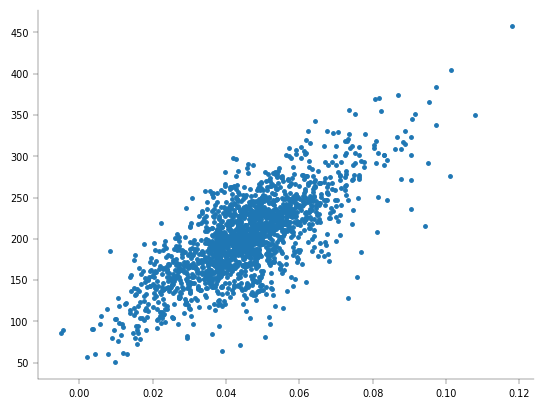

In [317]:
# There seems to be a correlation between surface turbulent fluxes and temperature diffusion at the lowest atmospheric level
plt.scatter(c_p * ds_sl[0].dt_tg_diffusion[:, -1], ds_sl[0].flux_lhe+ds_sl[0].flux_t)

In [318]:
# Have all tendencies in kJ/kg/day
time_array = ds_sl[0].time-0.5
n_day_seconds =  24 * 60**2
p_ind = -1
dh_dt_diff_sl = (c_p * ds_sl[0].dt_tg_diffusion[:, p_ind] + L_v * ds_sl[0].dt_qg_diffusion[:, p_ind]) * n_day_seconds/1000
dh_dt_conv_sl = (c_p * ds_sl[0].dt_tg_convection[:, p_ind] + L_v * ds_sl[0].dt_qg_convection[:, p_ind]) * n_day_seconds/1000
dh_dt_cond_sl = (c_p * ds_sl[0].dt_tg_condensation[:, p_ind] + L_v * ds_sl[0].dt_qg_condensation[:, p_ind]) * n_day_seconds/1000
dh_dt_rad_sl = c_p * ds_sl[0].tdt_rad[:, p_ind] * n_day_seconds/1000
mse_sl = moist_static_energy(ds_sl[0].temp, ds_sl[0].sphum, ds_sl[0].height)
dh_dt_sl = np.gradient(mse_sl[:, p_ind], time_array)

In [319]:
# Compute free troposphere vorticity at each time, lon and lat
ds_use = ds_base[0].isel(pfull=p_ind).load()
sin_lat = np.sin(np.deg2rad(ds_use.lat+90)).to_numpy().reshape(1, -1, 1)            # convert to spherical polars value so from 0 at pole to 180

h_div_v_sl = np.gradient(moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * ds_use.vcomp * sin_lat, 
                         np.deg2rad(ds_use.lat+90), axis=1) / (radius_earth * sin_lat) * n_day_seconds
h_div_u_sl = np.gradient(moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height) * ds_use.ucomp, 
                         np.deg2rad(ds_use.lon), axis=2) / (radius_earth * sin_lat) * n_day_seconds
h_div_omega_sl = np.gradient(ds_sl[0].omega * mse_sl, ds_sl[0].pfull*100, axis=-1)[:, p_ind] * n_day_seconds

(1750.0, 2000.0)

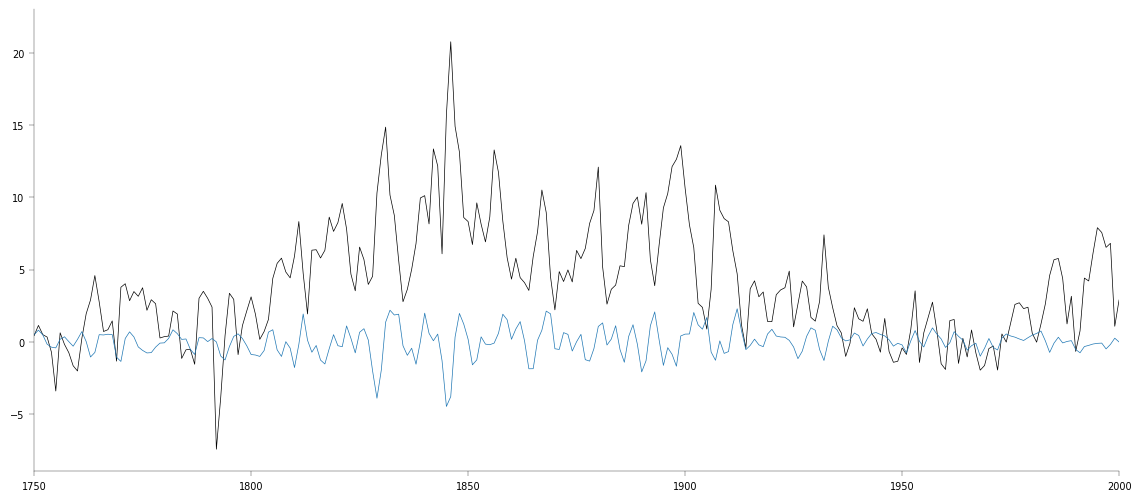

In [323]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(1, 1, figsize=(14,6))
# ax.plot(time_array, dh_dt_diff_sl)
# ax.plot(time_array, dh_dt_conv_sl)
# ax.plot(time_array, dh_dt_cond_sl)
# ax.plot(time_array, dh_dt_rad_sl)
ax.plot(time_array, (dh_dt_diff_sl+dh_dt_conv_sl+dh_dt_cond_sl+dh_dt_rad_sl), color='k')
ax.plot(time_array, dh_dt_sl)
# ax.plot(time_array, np.gradient(ds_sl[0].omega * mse_sl, ds_sl[0].pfull*100, axis=-1)[:, p_ind] * n_day_seconds + 
#         h_div_v_sl[:, lat_ind_sl, lon_ind_sl] + h_div_u_sl[:, lat_ind_sl, lon_ind_sl])
# ax.plot(time_array, np.gradient(ds_sl[0].omega * mse_sl, ds_sl[0].pfull*100, axis=-1)[:, p_ind] * n_day_seconds)
# ax.plot(time_array, h_div_v_sl[:, lat_ind_sl, lon_ind_sl] + h_div_u_sl[:, lat_ind_sl, lon_ind_sl])
# ax.plot(time_array,dh_dt_sl + h_div_v_sl[:, lat_ind_sl, lon_ind_sl] + h_div_u_sl[:, lat_ind_sl, lon_ind_sl]+h_div_omega_sl)
# ax.plot(time_array, h_div_u_sl[:, lat_ind_sl, lon_ind_sl]/100)
ax.set_xlim(1750, 2000)

(1750.0, 2000.0)

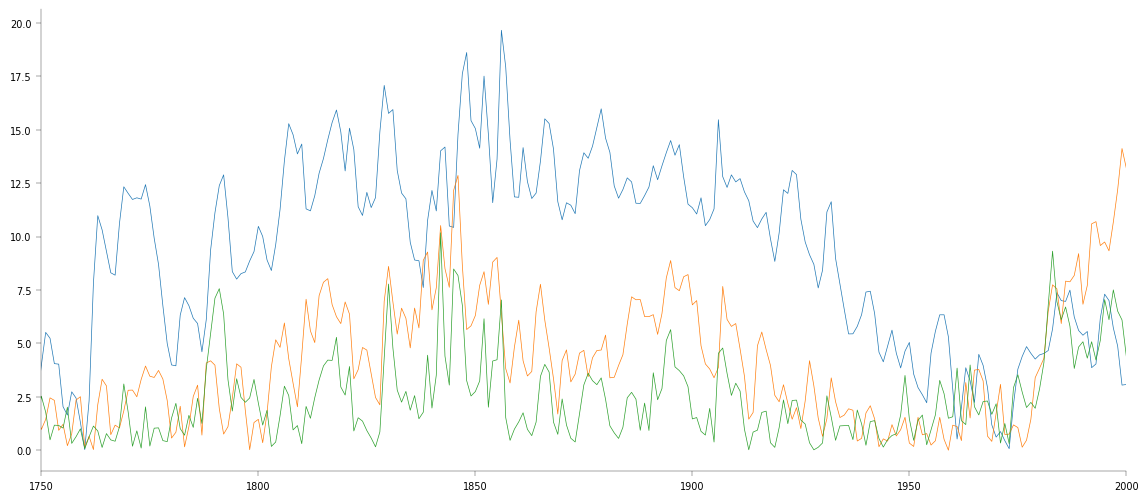

In [335]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(time_array, np.abs(ds_sl[0].ucomp[:, p_ind]))
ax.plot(time_array, np.abs(ds_sl[0].vcomp[:, p_ind]))
ax.plot(time_array, np.abs(ds_sl[0].omega[:, p_ind])*1000)
ax.set_xlim(1750, 2000)

(1750.0, 2000.0)

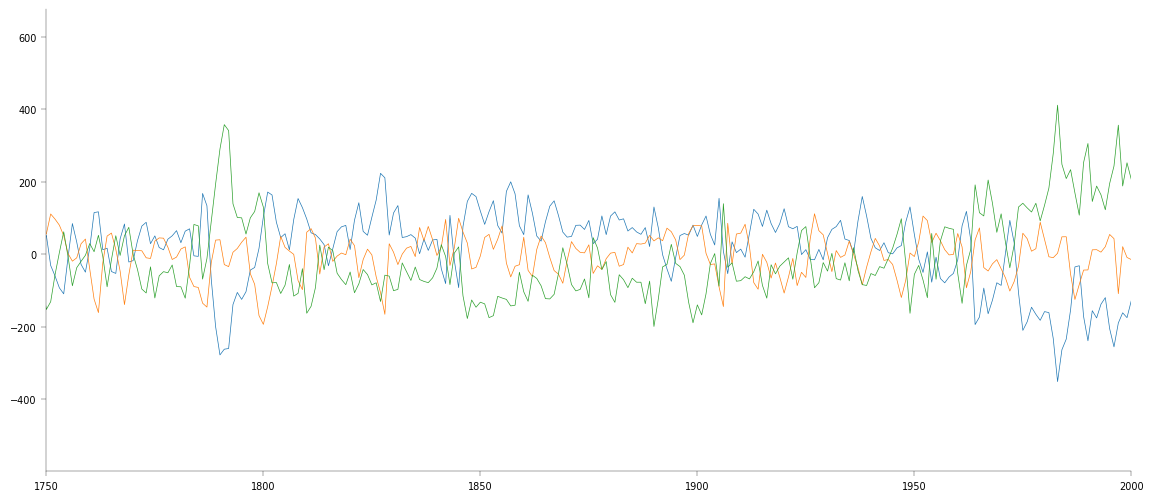

In [321]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))
ax.plot(time_array, h_div_v_sl[:, lat_ind_sl, lon_ind_sl])
ax.plot(time_array, h_div_u_sl[:, lat_ind_sl, lon_ind_sl])
ax.plot(time_array, h_div_omega_sl)
# ax.plot(time_array, c_p * np.gradient(ds_sl[0].temp[:, p_ind], time_array)/1000)
# ax.plot(time_array, L_v * np.gradient(ds_sl[0].sphum[:, p_ind], time_array)/1000)
ax.set_xlim(1750, 2000)

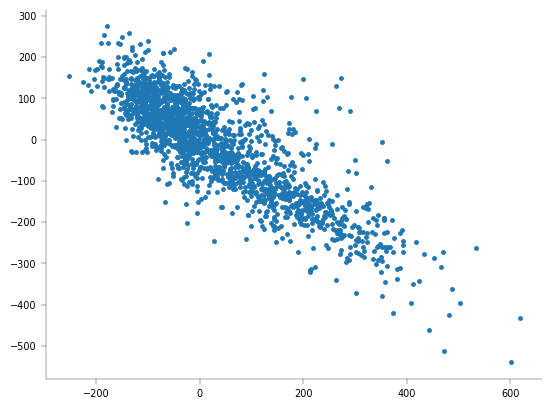

In [322]:
plt.scatter(h_div_omega_sl, h_div_v_sl[:, lat_ind_sl, lon_ind_sl])